# The effect of minimum wage on Unemployment: a synthetic control method study

## Abstract

Unemployment is a result of many factors, and thus the policy response to it also varies. Countries have adopted several measures – from on-the-job training, and improved labor laws, subsidies, and labor union support to manage unemployment. However, minimum wage still is one of the most controversial, contested, and studied supply-side policy measures. We propose a synthetic control method approach to understand the effect of the introduction of minimum wage in Germany on total unemployment levels. We compare a bucket of non-minimum wage countries to Germany over the 1991-2021 time period. Evidence conveys a statistical significance of the treatment effect of nearly a 5% reduction in unemployment levels. This result contradicts the labor economics Keynesian theory, opening the path to advanced and contemporaneous models.

## Introduction
The impact of the introduction and rise in the minimum wage on the employment conditions of workers has always been an extremely important and controversial topic. The minimum wage helps poor and low-income families earn enough income and help them exit poverty. However, the potential downside is that it may discourage employers from employing low-wage, low-skilled workers and cause job loss or widespread price increases. Labor economists have long studied whether minimum wages destroy jobs.

Different economic theories lead to different predictions and the effects on employment are frequently controversial. Neoclassical economic theory predicts that higher minimum wages will lead to lower employment. This may happen for two reasons: firstly, because minimum wages may force enterprises to raise the prices of their goods and services, and consumers or international buyers who face higher prices may therefore cut back on their demand (the so-called “scale effect”). Secondly, when low-wage workers become more “expensive” due to the minimum wage, firms may decide to replace some of them with more machines and a few skilled workers to operate these (the “substitution effect”). If these effects are large, aggregate employment levels of low-wage workers may decline. There is also likely to be a “cross-industry” effect, as employment is predicted to fall in labor-intensive industries, where the proportion of low-paid workers is higher and where labor costs represent a high proportion of total production costs for enterprises. In other industries, employment may remain unchanged or may even increase, as consumers spend more of their money on goods and services where prices are less affected by minimum wages.

Another theory suggests that employers exercise a degree of ‘monopsony power’ – a terminology relative to the gain of market power in employing a particular type of labor in a defined labor market - control the wages and keep them below the productivity contribution, thus pricing labor out of the market. Employers maximize their profit through production and employment expansion. “Search models” suggest that in imperfectly functioning labor markets, up to a certain level, the cost of minimum wages is drained through a combination of lower wage increases for more highly paid workers. In turn, the system experiences lower profit margins, higher productivity, and lower employee turnover. Macroeconomic theories suggest that higher wages raise labor costs for employers and increase the consumption demand among low-income workers and their families (more than high-income workers). These consumption effects might lead to an increase in aggregate demand and employment. Macroeconomic perspectives show that even if some low-productivity firms reduce employment, this does not necessarily mean that the aggregate level shrinks. The employment level may expand to other firms. Subsequently, higher wages may attract more people into the labor market. 

The macroeconomic foundations of the labor market and consumer theory are still in the refinement process. The global economy is experiencing more and more heterogeneity at the consumer level, and the lack of a structured theory is the main driver of research in this field. Multiple economists have tried to understand this, beginning with Card and Krueger in 1994, who were pioneers in conducting a systematic analysis of the possible consequences of a minimum wage rise in the United States. However, contemporaneous research is not only limited to the United States. Economists have tried to understand a variety of geographies. As economists and social scientists, our interests lie in understanding the evolution of such a phenomenon, as it is an integral part of our studies and everyday lives.

## DataSet

In [1]:
#basic libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

#World Bank API
import wbgapi as wb

#Statistics and Econometrics libraries
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from scipy.optimize import minimize

# Set parameters for pandas display functionalities
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'center')

# avoid Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Units of the analysis

We decided to focus on Germany since it recently introduced a minimum wage policy. Germany is a structured and robust economy, a member of the G7. Using Germany as a treatment unit for the analysis would represent meaningful evidence. We handpick the list of countries that have not yet introduced a minimum wage policy. These countries compose the list of counterfactuals in the synthetic control group.

In [2]:
# store the control group and treatement group into two lists

control = ['Austria', 'Bahrain', 'Brunei Darussalam', 'Burundi', 'Cyprus', 'Djibouti', 'Denmark', 'Egypt, Arab Rep.', 'Eritrea', 'Ethiopia', 
           'Finland', 'Iceland', 'Italy', 'Liechtenstein', 'Maldives', 'Namibia', 'Nauru', 'Norway', 'Rwanda', 
           'Sao Tome and Principe', 'Singapore', 'Somalia', 'South Sudan', 'Sweden', 'Switzerland', 'Tonga', 
           'Tuvalu', 'United Arab Emirates', 'Yemen, Rep.', 'Zimbabwe']

treat = ['Germany']

# create a list containing all the countries needed for the analysis

countries = control.copy()
countries.append(treat[0])

We collect data using the World Bank Open Data leveraging the API that is freely avaiable to make the import of the data faster and more efficient.

In [3]:
# store all countries with characteristics we want to include in the analysis
countries_df = wb.economy.DataFrame().reset_index().loc[: ,['id', 'name', 'incomeLevel']]

In [4]:
countries_df.head()

,id,name,incomeLevel
0,ABW,Aruba,HIC
1,AFE,Africa Eastern and Southern,
2,AFG,Afghanistan,LIC
3,AFW,Africa Western and Central,
4,AGO,Angola,LMC


Once we have collected a dataframe with the entire world, countries essential characteristics (id, name, Income Level), we procede in creating a list of id's for the countries under analysis. 

The id's are essential for database query extraction.

In [5]:
# store all the countries id for database queries extraction
countries_id = []

for c in countries:
    c_id = countries_df[countries_df.name == c].id.iloc[0]
    countries_id.append(c_id)

control_id = countries_id.copy()
control_id.remove(countries_df[countries_df.name == 'Germany'].id.iloc[0])

print('Control id:')
print(control_id)

treat_id = [countries_df[countries_df.name == 'Germany'].id.iloc[0]]
print('\nTreatment id:')
print(treat_id)

Control id:
['AUT', 'BHR', 'BRN', 'BDI', 'CYP', 'DJI', 'DNK', 'EGY', 'ERI', 'ETH', 'FIN', 'ISL', 'ITA', 'LIE', 'MDV', 'NAM', 'NRU', 'NOR', 'RWA', 'STP', 'SGP', 'SOM', 'SSD', 'SWE', 'CHE', 'TON', 'TUV', 'ARE', 'YEM', 'ZWE']

Treatment id:
['DEU']


### variables of interest

In order to extract data from the World Bank databases, we need to understand the variables of interest in the model. We use past literature to guide us through macroeconomic variables selection, extracted using the World Bank API. We decide to collect the following variables considering that many time series presented a plethora of missing values.

Output variables:
- Unemployment, total (% of total labor force) (modeled ILO estimate)

ILO estimates provide data at the micro level. Estimates for countries with broad limited labor market information have a higher uncertainty degree. To perform a punctual analysis, it is often necessary to restore to other sources that could provide more precise information regarding the needed information for the study.

Regressors:
- GDP per capita growth (annual %)
- Population growth (annual %)
- Inflation, consumer prices (annual %)
- Government expenditure on education, total (% of GDP)
- Gini index
- Employment in industry (% of total employment) (modeled ILO estimate)

In [6]:
# store the variable name with relative query code 

output_vars = {'unempl_t':'SL.UEM.TOTL.ZS'}

regres_vars = {'gdp_capita_growth':'NY.GDP.PCAP.KD.ZG',
               'pop_growth':'SP.POP.GROW', 
               'inflation':'FP.CPI.TOTL.ZG',
               'gov_exp_educ':'SE.XPD.TOTL.GD.ZS',
               'gini_index': 'SI.POV.GINI', 
               'empl_industry': 'SL.IND.EMPL.ZS'} 

all_vars = {**output_vars, **regres_vars}

# fill the data_raw container with the data
# It takes approximately 20 seconds to query the db

data_raw = dict()

for var, series in all_vars.items():
    data_raw[var] = wb.data.DataFrame(series, countries_id) #querying the World Bank Database
    
# export the data_raw dictionary as excel file as local backup
# good practice to have a copy saved of the data we are working with

data_folder = 'data_WB/'
try:
    os.mkdir(data_folder)
except:
    pass

for var in data_raw.keys():
    if str(var)+'.xlsx' not in os.listdir(data_folder):
        data_raw[var].to_excel(os.path.join(data_folder, str(var)+'.xlsx'))
        print(f'{var}.xlsx CREATED')
    elif str(var)+'.xlsx' in os.listdir(data_folder):
        print(f'{var}.xlsx NOT CREATED')

unempl_t.xlsx NOT CREATED
gdp_capita_growth.xlsx NOT CREATED
pop_growth.xlsx NOT CREATED
inflation.xlsx NOT CREATED
gov_exp_educ.xlsx NOT CREATED
gini_index.xlsx NOT CREATED
empl_industry.xlsx NOT CREATED


We have a slight concern about the nature of the data collected. Unemployment is a hard phenomenon to describe and tackle. We want to collect more variables of interest e.g migration flow, national income level, and percentage of workers divided into specific areas of the labor market. However, we have struggled to find the data on the World Bank. Other data sources like Bloomberg and Factset,  to which we had access using the Bocconi Library Database, did not help us in fulfilling this goal. We believe that data collection is a very demanding and long part of a project and/or paper. Considering that some time series scraped was full of missing values, we decided to focus on the aforementioned information. and we use this as starting point for a future, more in-depth analysis.

## Analysis

### Loading dataset

In [7]:
data_folder = 'data_WB/'
data = dict()

for file in os.listdir(data_folder):
        
    if file.endswith('.xlsx'): # avoid other files (unwanted) to be inserted in the dictionary needed for the analysis
        filename = file.split(".")[0]
        data[filename] = pd.read_excel(os.path.join(data_folder, file))
        data[filename].rename({'economy':'countries'}, axis='columns', inplace=True) # renaming column of countries
        data[filename].set_index('countries', inplace = True) # set the same index for all the dataframes in the dictionary

# main dataframe of the analysis
print(data['unempl_t'].T.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, YR1960 to YR2021
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARE     31 non-null     float64
 1   AUT     31 non-null     float64
 2   BDI     31 non-null     float64
 3   BHR     31 non-null     float64
 4   BRN     31 non-null     float64
 5   CHE     31 non-null     float64
 6   CYP     31 non-null     float64
 7   DEU     31 non-null     float64
 8   DJI     31 non-null     float64
 9   DNK     31 non-null     float64
 10  EGY     31 non-null     float64
 11  ERI     31 non-null     float64
 12  ETH     31 non-null     float64
 13  FIN     31 non-null     float64
 14  ISL     31 non-null     float64
 15  ITA     31 non-null     float64
 16  LIE     0 non-null      float64
 17  MDV     31 non-null     float64
 18  NAM     31 non-null     float64
 19  NOR     31 non-null     float64
 20  NRU     0 non-null      float64
 21  RWA     31 non-null     float64
 22  

We notice three aspects:
- Three countries (LIE, NRU, TUV) have no data reported for unemployment total
- There are almost half observations with no values, for all countries (is 62 years but only 31 non-null values)
- The name of the columns are not properly called

### Initial preprocessing

In [8]:
for var, df_var in data.items():
    df_var.columns = [year for year in range(1960,2022)]
    df_var.drop(index=['LIE', 'NRU', 'TUV'], inplace=True)
    data[var] =  df_var.loc[:, 1991:]

### Data manipulation

#### Panel Dataframe construction

We want now to create, from the dataset at our disposal in a dictionary form (up to now), a standard panel dataset. The dataset structure is composed of a country's column, a year column, and multiple columns including output and explanatory variables. 

In [9]:
# good practice to make a copy of the original dataframe so that we don't over-ride it
data_panel = data.copy()

years = [year for year in range(1991,2022)] # years of the analysis

counter = 0
for var, df_var in data_panel.items():
    
    # simply convert the columns in rows of the dataframe, 
    # sort the values to have the data displayed nicely
    df_var = pd.melt(df_var.reset_index(), 
                     id_vars= ['countries'],
                     value_vars = years,
                     var_name= 'years', 
                     value_name= var).sort_values(by=['countries', 'years'])
                                                                                
    if counter == 0:
        data_panel = df_var 
    
    elif counter != 0:
        # merge iteratively the dataframes into a single final df
        data_panel = data_panel.merge(df_var, how = 'outer', on = ['countries', 'years'])

    counter += 1

We also need to include two columns in the dataframe that are proper to a Diff-in-Diff setting: temporal dummy that refers to the occurrence of the treatment, cross-sectional column whether unit treated or not.

In [10]:
cols_to_add = ['post_treat', 'unit_treat']
treat_country = 'DEU'
treat_year = 2012

years_post_treat = [year for year in range(treat_year, 2022)]

# Add the two columns composed by only zeros (0)
data_panel[cols_to_add[0]], data_panel[cols_to_add[1]] = False, False

## Fill the columns just add with the correct values

#update post_treat column
for row in range(len(data_panel)): 
    if data_panel.loc[row, 'years'] in years_post_treat:
        data_panel.loc[row, 'post_treat'] = True

#update unit_treat column
for row in range(len(data_panel)):
    if data_panel.loc[row, 'countries'] == treat_country:
        data_panel.loc[row, 'unit_treat'] = True

The final piece is to add three columns relative to the trajectory of unemployment that we find useful to describe the trajectory itself. This practice is a common practice done in several studies that allow us to better describe the time series. We report three crucial lags that we believe could provide additional evidence since are the lags that refer to major peaks and valleys of German unemployent trajectory. Recall that this peculiar feature creation is done independently for all countries in the analysis.

In [11]:
data_panel['unempl_t_1997'] = 0
data_panel['unempl_t_2005'] = 0
data_panel['unempl_t_2010'] = 0
for c in data_panel.countries.unique():
    data_panel.loc[data_panel['countries'] == c,'unempl_t_1997'] =  data_panel.loc[(data_panel['countries'] == c) & (data_panel['years']== 1997),
                                                                                   'unempl_t'].values[0]
    data_panel.loc[data_panel['countries'] == c,'unempl_t_2005'] =  data_panel.loc[(data_panel['countries'] == c) & (data_panel['years']== 2005),
                                                                                   'unempl_t'].values[0]
    data_panel.loc[data_panel['countries'] == c,'unempl_t_2010'] =  data_panel.loc[(data_panel['countries'] == c) & (data_panel['years']== 2010),
                                                                                   'unempl_t'].values[0]

The prepared dataset is diplayed:

In [12]:
data_panel.head()

,countries,years,inflation,pop_growth,unempl_t,gdp_capita_growth,empl_industry,gov_exp_educ,gini_index,post_treat,unit_treat,unempl_t_1997,unempl_t_2005,unempl_t_2010
0,ARE,1991,NaN,5.776096,1.866,-4.800636,33.330002,NaN,NaN,False,False,1.98,3.12,2.481
1,ARE,1992,NaN,5.802706,1.842,-2.481187,33.360001,NaN,NaN,False,False,1.98,3.12,2.481
2,ARE,1993,NaN,5.692129,1.849,-4.341751,33.470001,NaN,NaN,False,False,1.98,3.12,2.481
3,ARE,1994,NaN,5.429052,1.806,1.247424,33.490002,NaN,NaN,False,False,1.98,3.12,2.481
4,ARE,1995,NaN,5.127893,1.800,1.354948,33.630001,NaN,NaN,False,False,1.98,3.12,2.481


#### NaN replacement

In [13]:
def fill_nan(df, treat_country, var):

    stacked_pivot = df[~df.loc[:, 'post_treat']].pivot(index='countries', columns = 'years')[var].T

    treat_stacked_pivot = stacked_pivot[treat_country]
    contr_stacked_pivot = stacked_pivot.drop(columns = treat_country)

    #treat_stacked_pivot.fillna(0, inplace = True)
    #contr_stacked_pivot.fillna(0, inplace = True)
    
    if 'gov_exp_educ' in var:
        ## replace the Treated Unit missing values of gov_exp_educ with the mean value
        mean = treat_stacked_pivot['gov_exp_educ'].mean(skipna = True)
        treat_stacked_pivot['gov_exp_educ'] = treat_stacked_pivot['gov_exp_educ'].fillna(mean)

    ## replace the Control Group missing values with the mean for each year
    contr_stacked_pivot['mean'] = contr_stacked_pivot.mean(axis=1)
     
    contr_stacked_pivot
    for col in contr_stacked_pivot.columns:
        contr_stacked_pivot[col] = contr_stacked_pivot[col].fillna(contr_stacked_pivot['mean'])
    contr_stacked_pivot = contr_stacked_pivot.drop(columns = 'mean')
    
    return treat_stacked_pivot, contr_stacked_pivot

### Plot Function

In [14]:
def plot_trend(df, var, title, year_shock = treat_year, treat = treat_country, control = 'Control Group', synth=None, post=False):
        
    # Pivot Table of Unemployment
    df = data_panel.copy()
    df = df.pivot(index='years', columns='countries', values=var).reset_index()
    
    ## select the list of countries
    countries = [col for col in df.columns if col!= 'years']
    
    ## compute the mean of each year for countries in the control group
    if post == False:
        df[control] = df[[col for col in countries if col != treat_country]].mean(axis=1)
        df.years = df.years.astype(int)
        out_graph = control
    
    ## create a column with the synthetic weights
    elif post == True:
        df[f'synth_{treat_country}'] = synth
        df.years = df.years.astype(int)
        out_graph = f'synth_{treat_country}'
        control = f'synth_{treat_country}'
        
    treat_color, control_color = 'royalblue', 'limegreen'
    
    #plot the trends
    fig = plt.figure(figsize=(10,6))
    plt.plot(df.years, df[treat], color = treat_color, lw=2, label= treat)
    plt.plot(df.years, df[out_graph], color = control_color, alpha = 1, lw=2, label = control)
    plt.axvline(x=year_shock, lw=2, ls='--', label='Min Wage Policy', color='red')
    plt.xticks(df.years, rotation = 0)
    plt.locator_params(axis='x', nbins=15)
    plt.grid(alpha = 0.2)
    plt.legend()
    plt.title('Unemployment Total, (% Total labor force)')
    plt.show()
    
    plot_folder = 'plot_figures/'
    try:
        os.mkdir(plot_folder)
    except:
        pass
    fig.savefig(os.path.join(plot_folder, title + '.png'), bbox_inches='tight', dpi=1200)

### Sythetic Control Model 

Abadie and Gardeazabal (2003) and Abadie et al. (2010) introduce the Synthetic Control method in contrast with the then most used Difference In Difference approach. Since then, this peculiar modeling approach has been widely used, especially for economic matters.
The Synthetic Control model is a clever way to represent a variable of interest using a counterfactual, artificially composed of units of varying weights (goal of the analysis). A theoretical issue with this type of analysis is the impossibility to observe the realization of the counterfactual. Therefore, using the synthetic control as a proxy, we can fairly assume that it would represent the Treatment unit as if the treatment never happened. Following this line of reasoning, we artificially create a Synthetic Germany (DEU) that never received a shock. We assess a comparative static of the model that leads us to consider a Treatment effect relative to the introduction of the shock.

We need to minimize the weights of the norm (distance) of the Treatment unit matrix and the Control units matrix before the shock took place in the system. The mathematical problem can be expressed in the following way.

We need to find the optimal $\hat{\beta}$ that are able to represent, as a convex combination, the pre-Treatment value of unemployment.

$$\hat{Y}_{t, pre} = \alpha + \sum_{i \in c} \hat{\beta_i}Y_{i, pre}$$

In order to do so, we can construct the following problem that allows us to find the optimal weights.

$$\hat{\beta} \ = \ \underset{\beta}{\mathrm{argmin}} \ \parallel X_{t, pre} - \beta X_{c, pre} \parallel \ = \ \sqrt{\sum_{p} \left(X_{t, pre, p} - \sum_{i \in c}\beta_i X_{i, pre, p} \right)^2 } \\
s.t. \ \sum_{i \in c}\beta_i = 1 \ , \ \beta_i \geq 0, \forall i$$

Thus, we can create a function that resembles our problem and finds the optimal weights for the model.

In [15]:
def loss_fct(x, X_t, X_c) -> float:
    return np.sqrt(np.mean((X_t - X_c@(x))**2))

def beta_hat(X_t, X_c):
    
    w_0 = [1/X_c.shape[1]]*X_c.shape[1]

    weights = minimize(fun = loss_fct,
                       args = (X_t, X_c),
                       x0 = np.array(w_0),
                       constraints=({'type': 'ineq', 'fun': lambda x: np.sum(x) - 1}),
                       bounds=[(0.0, 1.0)]*len(w_0),
                       options = {'disp':False})
    return weights

We want to select $\hat{Y}_{t, pre}$ such that $|Y_{t, pre} - \hat{Y}_{t, pre}|$ is the lowest.

Firstly, we need to create an algorithm that is able to create a list of combinations of all variables in the dataset.

In [16]:
# elaborate a mechanism to obtain all the combinations of the variables in the dataset
var = ['inflation', 'pop_growth', 'gdp_capita_growth', 'empl_industry', 'gov_exp_educ', 'gini_index']

vars_comb = []
for num in range(1, len(var)):
    comb = list(itertools.combinations(var, r= num))
    for i in range(len(comb)):
        temp_list = list()
        for j in range(num):
            el = str(list(itertools.combinations(var, r= num))[i][j])
            temp_list.append(el)
        vars_comb.append(temp_list)

# we decide to append the important features that give context to the analysis
for x in vars_comb:
    x.append('unempl_t')
    x.append('unempl_t_1997')
    x.append('unempl_t_2005')
    x.append('unempl_t_2010')

In [17]:
best_comb = False
best_discr = np.inf

for comb in vars_comb:
    # get the data the panel_data
    df = data_panel.copy()

    # perfrom NaN removal
    treat_stacked_pivot, contr_stacked_pivot = fill_nan(df, treat_country, comb)

    # get the data
    X_tr = treat_stacked_pivot.values
    X_ct = contr_stacked_pivot.values

    # run the model
    germany_weights = beta_hat(X_tr, X_ct)

    # create synthetic Germany
    germany_synth = df[df.loc[:, 'countries']!=treat_country].pivot(index='years',
                                                                    columns = 'countries')['unempl_t'].values@(germany_weights.x)
    # collect True Germany
    real_germany = df[df.loc[:, 'countries'] == treat_country]['unempl_t'].values

    summ = 0
    for i in range(len(germany_synth)):
        summ += np.abs(germany_synth[i] - real_germany[i])

    if summ < best_discr:
        best_comb = comb
        best_discr = summ

print(f'The best combination of variables is:')
print(f'{best_comb}')

The best combination of variables is:
['inflation', 'gov_exp_educ', 'unempl_t', 'unempl_t_1997', 'unempl_t_2005', 'unempl_t_2010']


In [18]:
# get the data the panel_data
df = data_panel.copy()

# perfrom NaN removal
treat_stacked_pivot, contr_stacked_pivot = fill_nan(df, treat_country, best_comb)

# get the data
X_tr = treat_stacked_pivot.values
X_ct = contr_stacked_pivot.values

# run the model
germany_weights = beta_hat(X_tr, X_ct)

# create synthetic Germany
germany_synth = df[df.loc[:, 'countries']!=treat_country].pivot(index='years',
                                                                columns = 'countries')['unempl_t'].values@(germany_weights.x)
# collect True Germany
real_germany = df[df.loc[:, 'countries'] == treat_country]['unempl_t'].values

Before proceeding to the Results section, we want to stress the fact that the Test of Significance with inclusion of the Null Hypothesis is presented in the next section to give more flow to the analysis and comprehension of the results obtained.

## Results

### Synthetic Control Result

The Following plot present the composition of the Control Group where countries are uniformly characterizing the group.

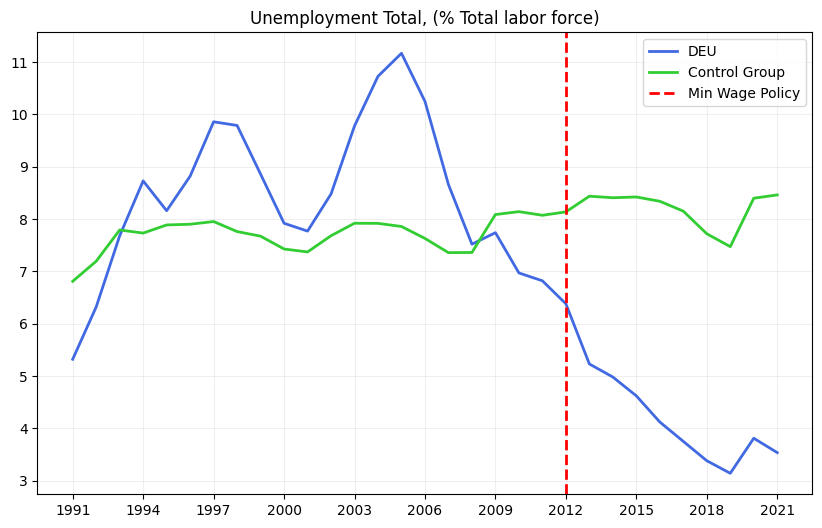

In [19]:
plot_trend(data_panel, 'unempl_t', title= 'unempl_trend') 

The following plot shows the trajectory of DEU and the synthetic composition of DEU using the Synthetic Control Model. After the treatment effect, the DEU unemployment trajectory drifts downward while the synthetic DEU keeps its cyclical path. Unemployment is a very procyclical variable, it goes up during economic expansion cycles and plummets during recessions. What we can evince from this graph is that there could be evidence that the introduction of the minimum wage has helped a decrease in unemployment, a fact that is not experienced by the synthetic counterfactual (the green line).

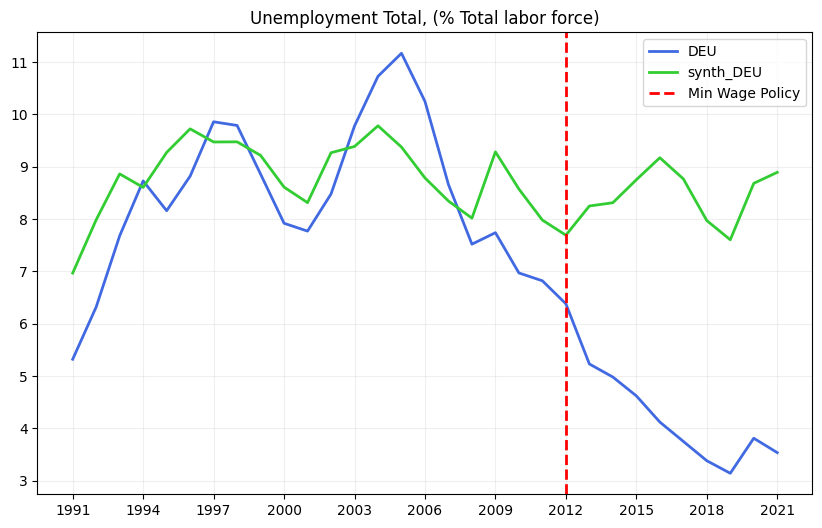

In [20]:
plot_trend(data_panel, 'unempl_t', title = 'unempl_synt_trend', synth=germany_synth, post=True)

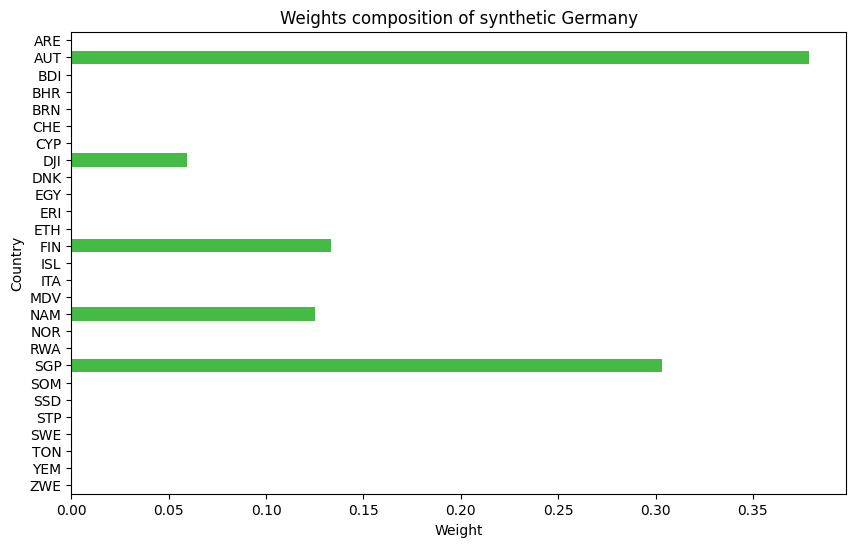

In [21]:
## create the bar plot to evince the weight associated to each country for the synthetic control methid construction

df = data_panel.copy()
countries_lab = list(df.countries.unique())
countries_lab.remove('DEU')
countries = [i for i in range(1, len(countries_lab)+1)]
weights = np.round(germany_weights.x, 4)

data_weights = pd.DataFrame({'Country': countries_lab, 'Weight': weights})
plot_folder = 'plot_figures/'
plt.figure(figsize=(10, 6))
sns.barplot(data=data_weights, x='Weight', y='Country', color = "limegreen").set(title='Weights composition of synthetic Germany');
plt.savefig(plot_folder + 'weights_bar.png', bbox_inches='tight', dpi=1200)

### Treatment Effect

The following plot intends to describe the Treatment Effect of the minimum wage intriduction. The following trend, is the difference, at every point, between the actual path of DEU unemployment and the synthetic one. As we can see, there is a 0 mean trend line where Unempployment gap moves around before the introduction of minimum wage. However, after 2012, the gap between the two time series diverges. The bottom is reached in 2021 when the gap was around 5% of difference. This suggest that unemployment in Germany is on average, 500 basis points lower than its artificial counterfactual. The introduction in minimum wage could have influenced the reduction in unemployment.

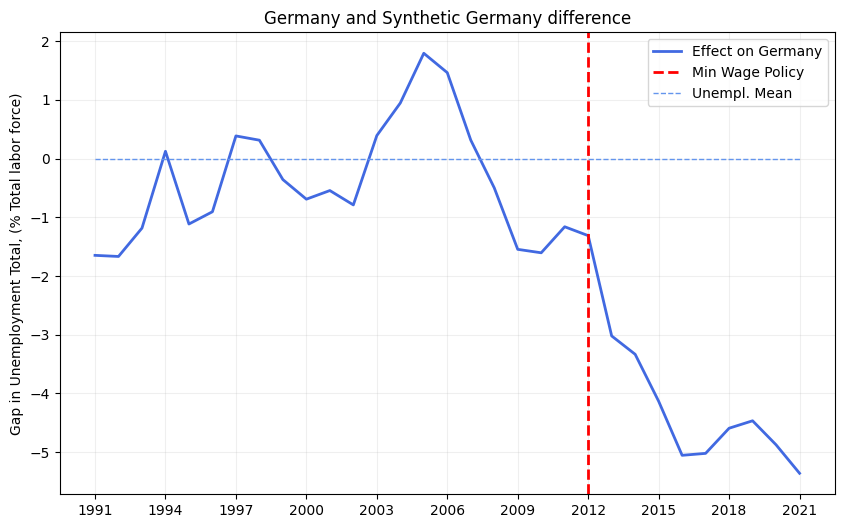

In [22]:
# plot the treatment effect of Germany
df = data_panel.copy()
fig = plt.figure(figsize=(10,6))
plt.plot(list(df.years.unique()), df[df.loc[:, 'countries'] == treat_country]['unempl_t'].values - germany_synth,
         label='Effect on Germany', lw = 2, color = 'royalblue')

plt.axvline(x=treat_year, lw=2, ls='--', label='Min Wage Policy', color='red')
plt.hlines(y=0, xmin = 1991, xmax = 2021, lw=1, ls= '--', color = 'cornflowerblue', label = 'Unempl. Mean')
plt.xticks(list(df.years.unique()), rotation = 0)
plt.locator_params(axis='x', nbins=15)
plt.title('Germany and Synthetic Germany difference')
plt.ylabel('Gap in Unemployment Total, (% Total labor force)')
plt.grid(alpha = 0.2)
plt.legend();

plot_folder = 'plot_figures/'
try:
    os.mkdir(plot_folder)
except:
    pass
fig.savefig(os.path.join(plot_folder, 'gap_unempl' + '.png'), bbox_inches='tight', dpi=1200)

### Fisher Exact Test

To assess the statistical significance of the result just obtained we need to perform the Fisher Exact Test. The aim is to perform a simulation of treatment occurrence on all the states of the analysis. Once at the time, we introduce the same minimum wage effect, use the same model and check if the result obtained on Germany is driven by randomicity or if there is statistical evidence of the shock on the treatment unit. The underneath idea is that, if the policy has no effect on the Treatment unit (DEU) then, the effect that is observed on all other countries should not be significantly different from the effect that would be observed for other countries.

The aforementioned statement can be rephrased. We construct a test of hypothesis where the Null hypothesis states that there is no treatment effect on Germany while the alternative states that there is a treatment effect on Germany. We allow for the construction of a two-sided test:

$$\begin{cases}
H_0: \tau = Y_t - \hat{Y}_t = 0\\
H_1: \tau = Y_t - \hat{Y}_t \neq 0\\
\end{cases}$$

In [23]:
def synthetic_permutation(df, var = best_comb):
    df['synthetic'] = 0
    
    for country in df.countries.unique():
        treat_stacked_pivot, contr_stacked_pivot = fill_nan(df, country, var)
        X_tr, X_ct = treat_stacked_pivot.values, contr_stacked_pivot.values
        
        weights = beta_hat(X_tr, X_ct)
        
        synth = df[df.loc[:, 'countries']!=country].pivot(index='years',
                                                                    columns = 'countries')['unempl_t'].values@(weights.x)
            
        df.loc[df['countries'] == country, 'synthetic'] =  synth
    
    return df  

In [24]:
## create a function to define the pretreatment error
def pre_treat_error(df, c):
    Y = df[(~df.loc[:, 'post_treat']) & (df.loc[:, 'countries'] == c)]['unempl_t'].values
    Y_synth = df[(~df.loc[:, 'post_treat']) & (df.loc[:, 'countries'] == c)]['synthetic'].values
    gap = Y - Y_synth
    MSE = (gap**2)
    return MSE.mean()

We create the simulation and we plot the results.

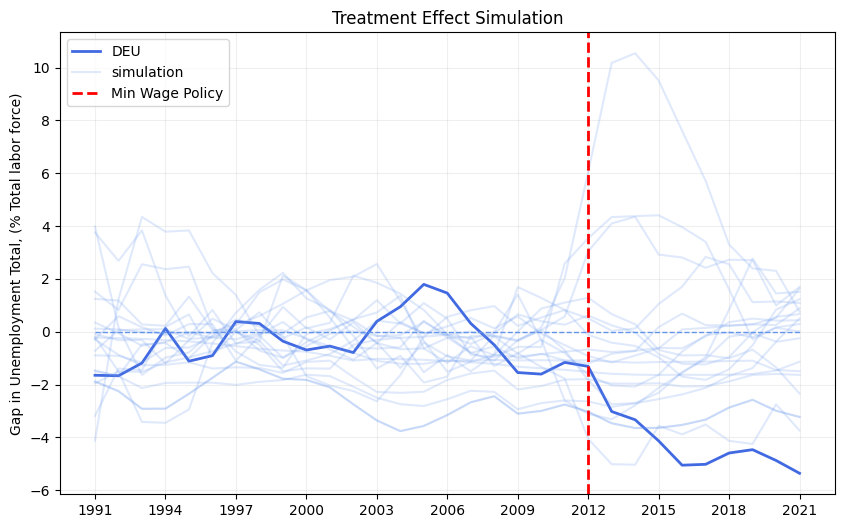

In [25]:
## do the anlaysis on all the countries as if they had received the treatment
df = synthetic_permutation(df, best_comb)

control_countries = df.countries.unique().tolist()
control_countries.remove(treat_country)

## prepare for plotting
fig = plt.figure(figsize=(10,6))

# plot the gap for Germany
plt.plot(df.years.unique(), 
         df[df.loc[:, 'countries'] == treat_country]['unempl_t'].values - df[df.loc[:, 'countries'] == treat_country]['synthetic'].values, 
         color = 'royalblue', alpha = 1, lw=2, label=treat_country)

# plot the simulations
for c in control_countries:
    MSE_c = pre_treat_error(df, c)
    # remove the countries that have a very large pre-treatment error
    if MSE_c < 10:
        if c == control_countries[-1]:
            plt.plot(df.years.unique(), df[df.loc[:, 'countries'] == c]['unempl_t'].values - df[df.loc[:, 'countries'] == c]['synthetic'].values, 
                 color = 'cornflowerblue', alpha=0.2, label = 'simulation')
            
        plt.plot(df.years.unique(), df[df.loc[:, 'countries'] == c]['unempl_t'].values - df[df.loc[:, 'countries'] == c]['synthetic'].values, 
                 color = 'cornflowerblue', alpha=0.2)

plt.axvline(x=treat_year, lw=2, ls='--', label='Min Wage Policy', color='red')
plt.hlines(y=0, xmin = 1991, xmax = 2021, lw=1, ls = '--', color = 'cornflowerblue')
plt.xticks(list(df.years.unique()), rotation = 0)
plt.locator_params(axis='x', nbins=15)
plt.title('Treatment Effect Simulation')
plt.ylabel('Gap in Unemployment Total, (% Total labor force)')
plt.grid(alpha = 0.2)
plt.legend();

plot_folder = 'plot_figures/'
try:
    os.mkdir(plot_folder)
except:
    pass
fig.savefig(os.path.join(plot_folder, 'Fisher_Exact_Test' + '.png'), bbox_inches='tight', dpi=1200)

The simulation yields an interesting result. The treatment effect on Germany in 2021 is the lowest among all the countries that took part in the analysis. The evidence that the treatment effect of the policy is statistically significant and not driven by chance. We evaluate the treatment effects of all countries, we store the results in a container.

In [26]:
## create a list of effect of the treatment in the last year of the observations

effects = list()
countries = df.countries.unique().tolist()
countries_no_treat_country = countries.remove(treat_country)
for c in countries:
    MSE_c = pre_treat_error(df, c)
    ## effect on the last time period observation
    if MSE_c < 10:
        eff = df[df.loc[:, 'countries'] == c]['unempl_t'].values[-1] - df[df.loc[:, 'countries'] == c]['synthetic'].values[-1]
        effects.append(eff)

treat_effect_deu = df[df.loc[:, 'countries'] == treat_country]['unempl_t'].values[-1] - df[df.loc[:, 'countries'] == treat_country]['synthetic'].values[-1]
print(f'The Min Wage Policy Effect on Germany is : {treat_effect_deu}')

The Min Wage Policy Effect on Germany is : -5.358531382240704


Once we have stored the placebo effects of all countries accoring to the permutation procedure, we can estimate the p-value as the proportion of times the treatment effect of minimum wage policy introduction on Germany is higher, in absolute values, compared to the placebo treatment effects estimated for the year 2021. We can proceed by identifying the statistics as: 

$$p_{val} = \frac{1}{N} \sum_{n=1}^{N-1} \big | \tau^{DEU} > \tau_n \big |$$

In [27]:
p_val = np.mean(np.abs(treat_effect_deu > effects))
p_val

0.0

It can be concluded that the effect of the minimum wage policy on Germany is statistically significant with respect to the countries taken as counterfactuals on which the placebo effect has been estimated. We now proceed with a visualization of the results to get a sense of how the treatement effects of the countries are distributed.

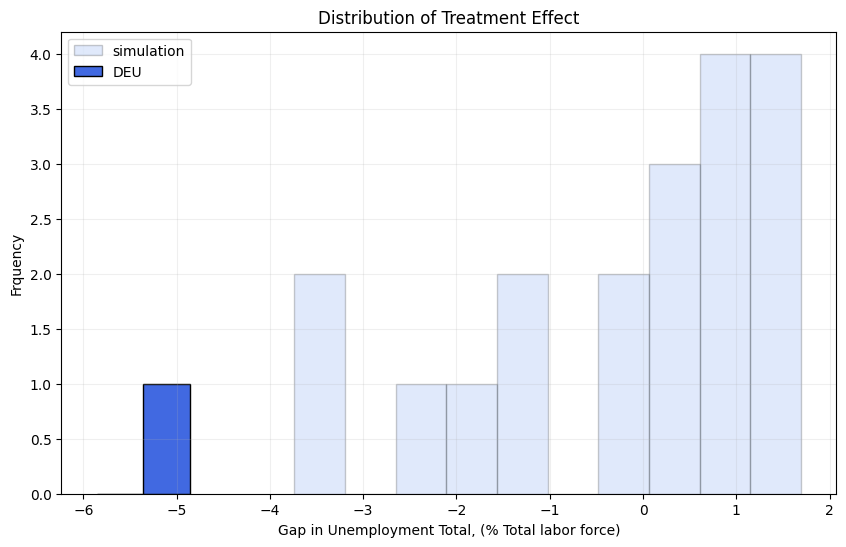

In [28]:
fig = plt.figure(figsize=(10,6))

plt.hist(effects, bins = 10, color = 'cornflowerblue', alpha = 0.2, label = 'simulation', ec='black')
plt.hist([treat_effect_deu], bins=2, color="royalblue", label="DEU", ec='black');
plt.ylabel("Frquency")
plt.xlabel("Gap in Unemployment Total, (% Total labor force)")
plt.title("Distribution of Treatment Effect")
plt.grid(alpha = 0.2)
plt.legend();

plot_folder = 'plot_figures/'
try:
    os.mkdir(plot_folder)
except:
    pass
fig.savefig(os.path.join(plot_folder, 'HP_test' + '.png'), bbox_inches='tight', dpi=1200)

## Conclusion

The study presented an overview of the synthetic control methodology for economic analysis. Moreover, we proposed a practical application of a debated subject like minimum wage introduction as a means to mitigate the level of unemployment. We collected several macroeconomic variables from World Bank, constructed the dataset, and deployed the theoretical model. We have discovered that the introduction of minimum wage helped Germany to reduce unemployment by 5% compared to the bucket of countries, used as counterfactuals, that did not introduce the same supply-side policy. To assess statistical significance, we have performed a permutation test (e.g. "The Fisher Exact Test") on the units of the analysis which has delivered the result we hoped to find: the outcome rejected the Null Hypothesis - no treatment effect associated with the introduction of minimum wage in Germany.
The result contradicts the classical Keynesian labor economics theory: according to it the minimum wage rise or similar supply-side policies were disincentivized, due to its negative effects on the aggregate level of employment and output. Furthermore, we have brought evidence coherent with the work done by Card & Kruger. Therefore, our work suggests a novel interpretation of the most recent developments in the field of macro and labor economics as the New Keynesian models are trying to grasp. 

Some limitations to our study include the data sources and data reliability, as more data will be available, we can expand the analysis further and keep track of the progress Germany makes relative to the level of unemployment. Given the recession starting at the time of writing this document, it would be interesting to keep the study updated. The labor market is shrinking to cool the economy down, and it will have repercussions on job postings and the level of unemployment. Moreover, we would need to broaden our dataset and the collected variables that could provide more evidence on the level of unemployment itself.

## References

- Yusoff, N. M., Nordin, N., & Nordin, N. (2023). The Impact of Minimum Wage on Economic Growth: Empirical Analysis on Developed and Developing Countries. In B. Alareeni & A. Hamdan (Eds.), Innovation of Businesses, and Digitalization during Covid-19 Pandemic (pp. 463–472). Cham: Springer International Publishing.
- Chi‐Chur Chao, Leonard F. S. Wang, Corporate governance, firm dynamics, and wage inequality, The Manchester School, 10.1111/manc.12396, 90, 3, (341-353), (2022).
- Merrill-Francis, M., Vernick, J. S., McGinty, E. E., & Pollack Porter, K. M. (2022). Association Between Fatal Occupational Injuries and State Minimum-Wage Laws, 2003–2017. American Journal of Preventive Medicine, 62(6), 878–884. doi:10.1016/j.amepre.2021.09.022
- Topazian, R. J., Hatton, C. R., Barry, C. L., Levine, A. S., & McGinty, E. E. (2022). Public support for U.S. social safety net policies throughout the COVID-19 pandemic. Preventive Medicine, 154, [106873]. https://doi.org/10.1016/j.ypmed.2021.106873
- Mitre‐Becerril, D., & Chalfin, A. (2021). Testing public policy at the frontier: The effect of the $15 minimum wage on public safety in Seattle. Criminology & Public Policy, 20(2), 291–328. doi:10.1111/1745-9133.12539
- Katzkowicz, Sharon & Pedetti, Gabriela & Querejeta, Martina & Bergolo, Marcelo, 2021.
- "Low-skilled workers and the effects of minimum wage in a developing country: Evidence based on a density-discontinuity approach," World Development, Elsevier, vol. 139(C).
- Jhon J. Mora & Juan Muro, 2020. "Wage–employment elasticity: a meta-analysis referring to Colombia," Journal of Economic Studies, Emerald Group Publishing, vol. 47(6), pages 1495-1505, April.
- Comparative politics and causal evaluation of structural reforms: The case of the UK national minimum wage introduction König, Thomas, Guido Ropers, and Anika Buchmann.
- Chu, A. C., Kou, Z., & Wang, X. (2020). Dynamic effects of minimum wage on growth and innovation in a Schumpeterian economy. Economics Letters, 188, 108943. doi:10.1016/j.econlet.2020.108943
- Chytilová, Helena & Frejlich, Petr. (2020). Concept of Minimum Wage Controversy: The Case of the Czech Republic. Politická ekonomie. 68. 423-442. 10.18267/j.polek.1285. 
- Gieyoung Lim & Chong-Uk Kim, 2018. "Minimum Wage and Unemployment: An Empirical Study on OECD Countries," Journal of Reviews on Global Economics, Lifescience Global, vol. 7, pages 1-9.

- Abadie, Alberto, and Javier Gardeazabal. 2003. "The Economic Costs of Conflict: A Case Study of the Basque Country ." American Economic Review, 93 (1): 113-132. DOI: 10.1257/000282803321455188

- Alberto Abadie, Alexis Diamond & Jens Hainmueller (2010) Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program, Journal of the American Statistical Association, 105:490, 493-505, DOI: 10.1198/jasa.2009.ap08746

- Wikipedia contributors. (2022, December 2). List of countries by minimum wage. Wikipedia. https://en.wikipedia.org/wiki/List_of_countries_by_minimum_wage

- ILO Department of Statistics. (n.d.). ILO Modelled Estimates and Projections (ILOEST). ILOSTAT. https://ilostat.ilo.org/resources/concepts-and-definitions/ilo-modelled-estimates/
- World Bank Open Data | Data. (n.d.). https://data.worldbank.org

- World Bank Open Data - Python API. https://github.com/tgherzog/wbgapi